In [1]:
from PIL import Image
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
from os.path import join
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

# Limit GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.get_logger().setLevel('INFO')
df = pd.read_csv(r"E:\Documentos\02_Programming\A-data-driven-approach-to-marking-of-plastic-materials-by-laser-micro-machining-2\Image processing\Contrast and Histograms\Contrast_results_DOE All.csv")
df



Image   Contrast
0     1 (2).tif  54.554695
1     1 (3).tif  53.140022
2         1.tif  55.272499
3    10 (2).tif  54.911386
4    10 (3).tif  53.541531
..          ...        ...
238  81 (3).tif  39.963333
239      81.tif  38.800941
240   9 (2).tif   9.737929
241   9 (3).tif   9.825601
242       9.tif   9.133471

[243 rows x 2 columns]

In [2]:
# Your data directory
data_dir = r"E:\Documentos\01_DTU\DTU-TFM\Fotos\DOE\2\All cropped"
image_exts = ['.tif']

# Assuming df is your DataFrame containing 'Image' and 'Contrast' columns
# label_dict = pd.Series(df['Contrast'].values, index=df['Image']).to_dict()

# If your DataFrame is already a dictionary, you can directly use it
label_dict = df.set_index('Image')['Contrast'].to_dict()

# Get a list of all .tif files in the directory
image_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if any(f.endswith(ext) for ext in image_exts)]

# Load Images and Labels
images = []
labels = []

# New size for the resized images
new_size = (512, 512)

for image_file in tqdm(image_files, desc="Loading Images"):
    # Load image
    img = Image.open(image_file)
    img = img.resize(new_size)  # Resize the image
    img = np.array(img) / 255.0  # Convert to numpy array and normalize pixel values
    img = tf.cast(img, tf.float32) / 255.0
    
    # Get the corresponding label from the dictionary
    label = label_dict[os.path.basename(image_file)]
    
    # Append to lists
    images.append(img)
    labels.append(label)

# Convert lists to arrays
images = np.array(images)
labels = np.array(labels)

# Check the shape of the first resized image and label
print("Shape of the first resized image:", images[0].shape)
print("Label of the first image:", labels[0])


Loading Images: 100%|██████████| 243/243 [00:18<00:00, 13.07it/s]


Shape of the first resized image: (512, 512, 4)
Label of the first image: 54.5546946574834


In [3]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Check the shapes of the training and test sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (194, 512, 512, 4)
Shape of X_test: (49, 512, 512, 4)
Shape of y_train: (194,)
Shape of y_test: (49,)


Epoch 1/80
87/87 [==============================] - 10s 76ms/step - loss: 328.5338 - mean_squared_error: 328.5338 - val_loss: 343.3928 - val_mean_squared_error: 343.3928
Epoch 2/80
87/87 [==============================] - 6s 72ms/step - loss: 193.3661 - mean_squared_error: 193.3661 - val_loss: 224.9974 - val_mean_squared_error: 224.9974
Epoch 3/80
87/87 [==============================] - 6s 72ms/step - loss: 187.6758 - mean_squared_error: 187.6758 - val_loss: 249.7066 - val_mean_squared_error: 249.7066
Epoch 4/80
87/87 [==============================] - 6s 73ms/step - loss: 180.2957 - mean_squared_error: 180.2957 - val_loss: 224.6764 - val_mean_squared_error: 224.6764
Epoch 5/80
87/87 [==============================] - 6s 72ms/step - loss: 220.5871 - mean_squared_error: 220.5871 - val_loss: 227.8883 - val_mean_squared_error: 227.8883
Epoch 6/80
87/87 [==============================] - 6s 72ms/step - loss: 176.9277 - mean_squared_error: 176.9277 - val_loss: 256.5930 - val_mean_squared_e

INFO:tensorflow:Assets written to: CNN.model\assets


INFO:tensorflow:Assets written to: CNN.model\assets


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


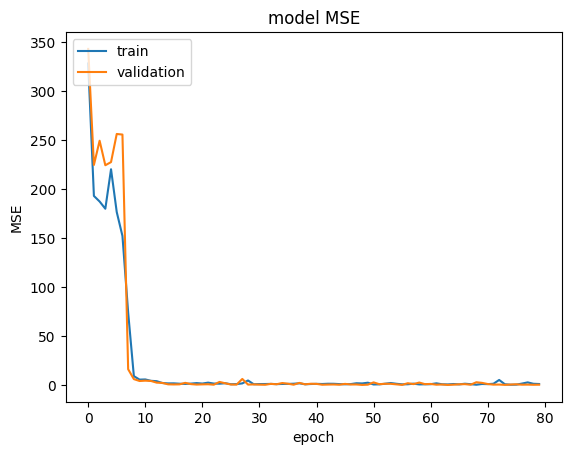

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout

from tensorflow.keras.optimizers import Adam

optimizer = Adam(clipvalue=0.5)  # Adjust the clipvalue as needed

# Building the model
model = Sequential()

model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mean_squared_error"])
# 3 convolutional layers
model.add(Conv2D(32, (3, 3), input_shape = X_test.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 hidden layers
model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(64))
model.add(Activation("relu"))

# The output layer with 1 neuron, for 1 continuous output
model.add(Dense(1, activation='linear'))

# Compiling the model using some basic parameters
model.compile(loss="mean_squared_error",
                optimizer="adam",
                metrics=["mean_squared_error"])

# Training the model, with 40 iterations
# validation_split corresponds to the percentage of images used for the validation phase compared to all the images
# Training the model
history = model.fit(X_train, y_train, batch_size=2, epochs=60, validation_split=0.1)


# Saving the model
model_json = model.to_json()
with open("model_moredata.json", "w") as json_file :
    json_file.write(model_json)

model.save_weights("model_moredata.h5")
print("Saved model to disk")

model.save('CNN.model')

# Printing a graph showing the MSE changes during the training phase
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

Loading Images: 100%|██████████| 15/15 [00:00<00:00, 20.90it/s]


Shape of the first resized image: (512, 512, 4)
Label of the first image: 54.5546946574834
1/1 [==============================] - 2s 2s/step


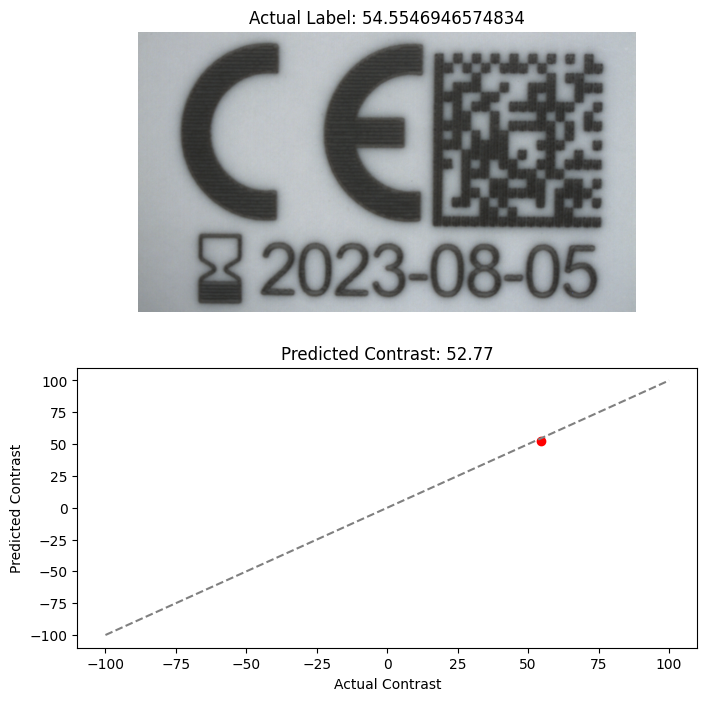

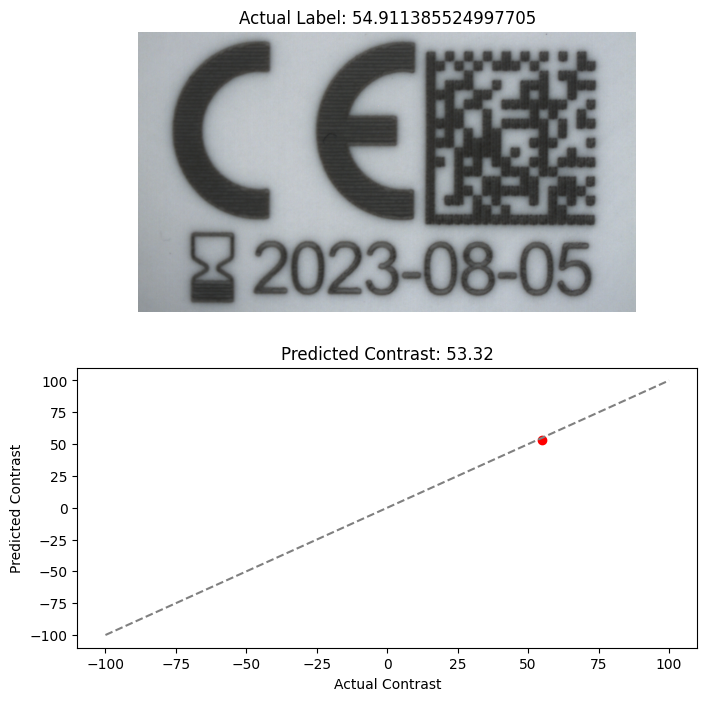

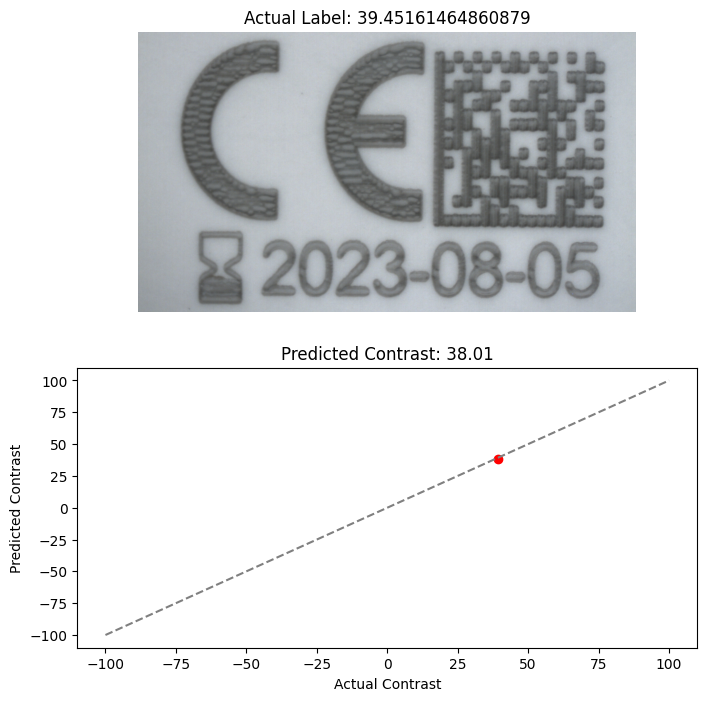

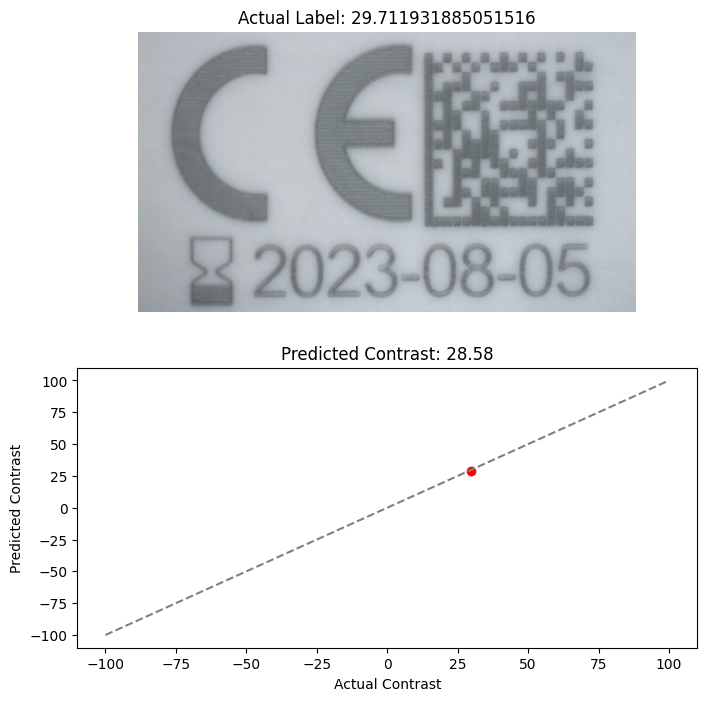

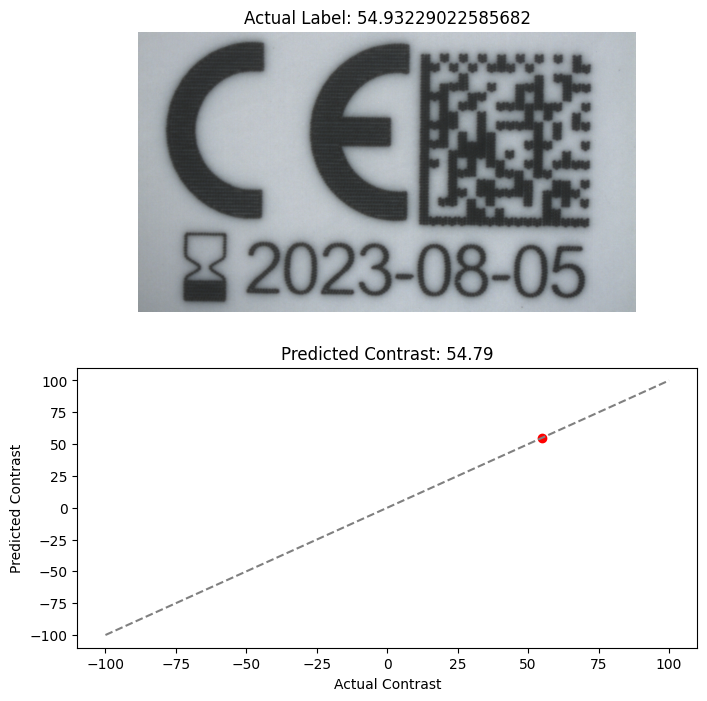

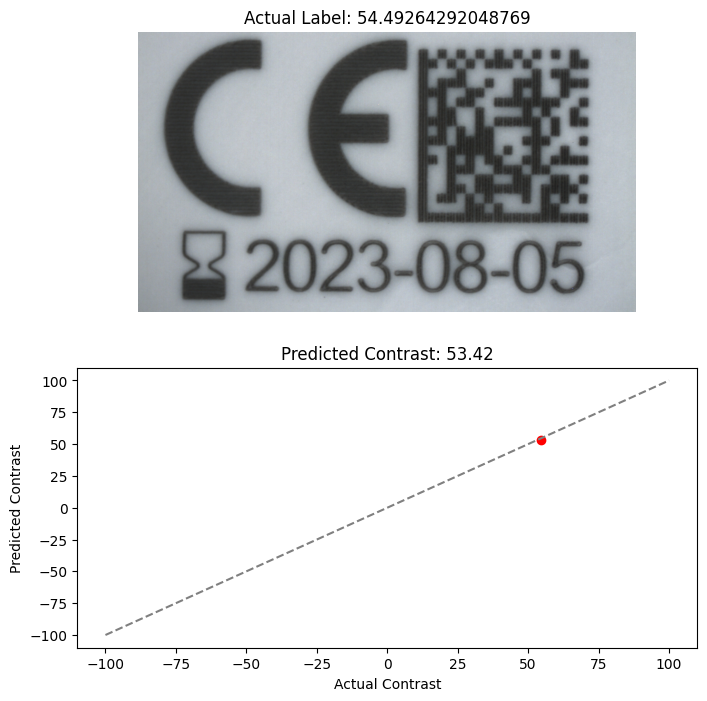

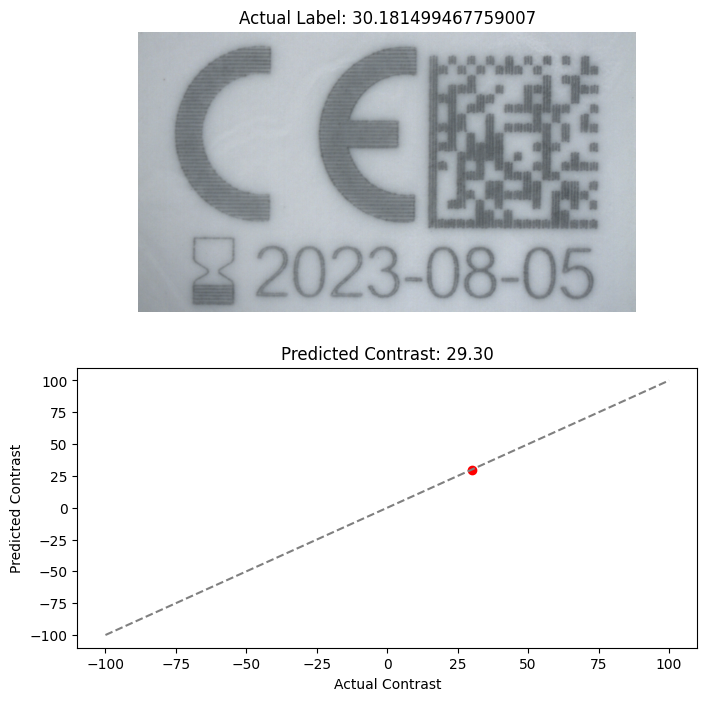

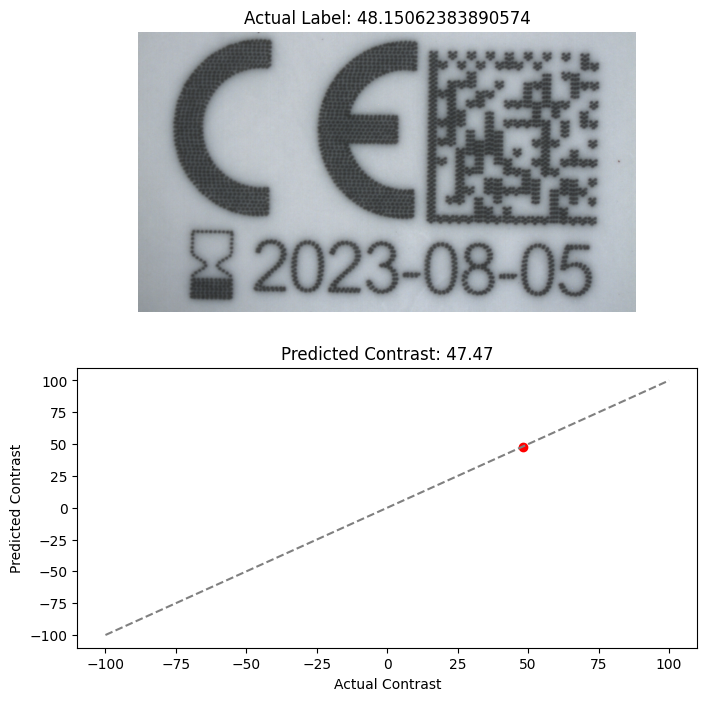

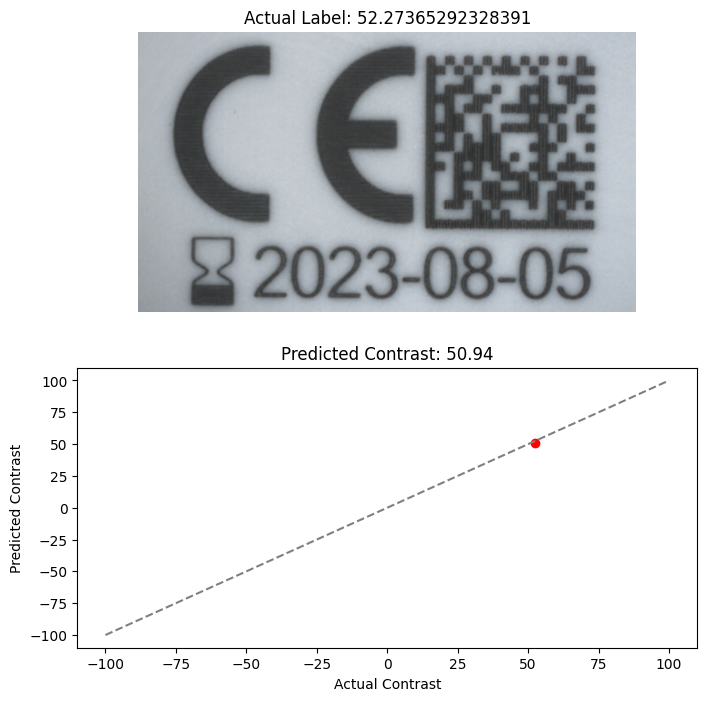

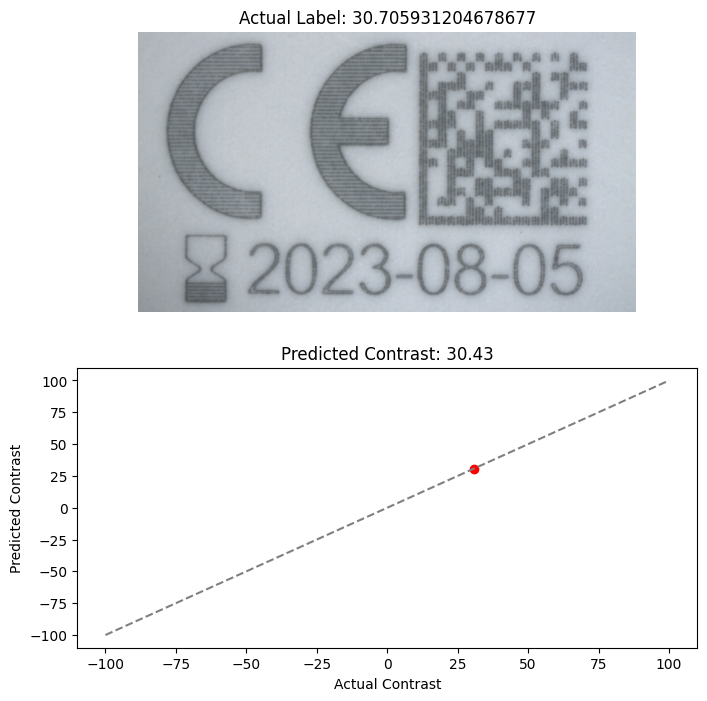

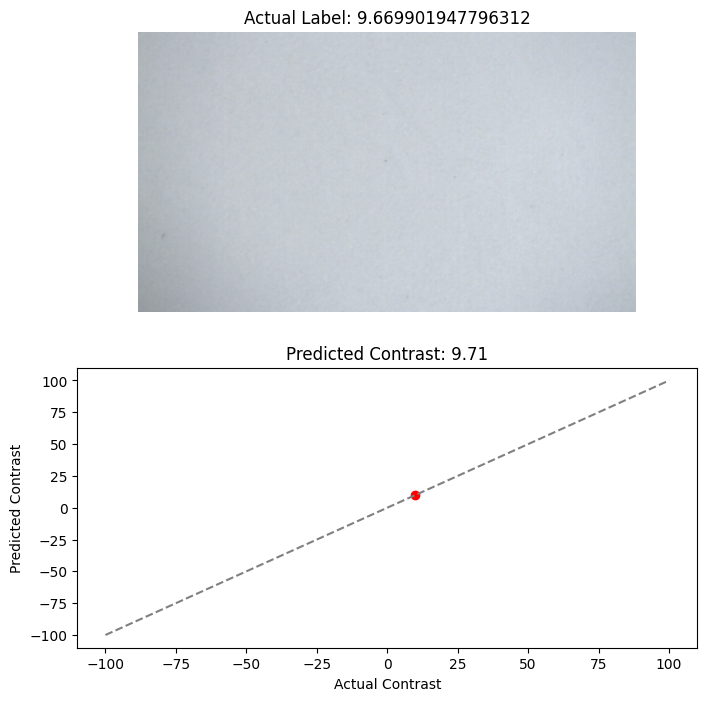

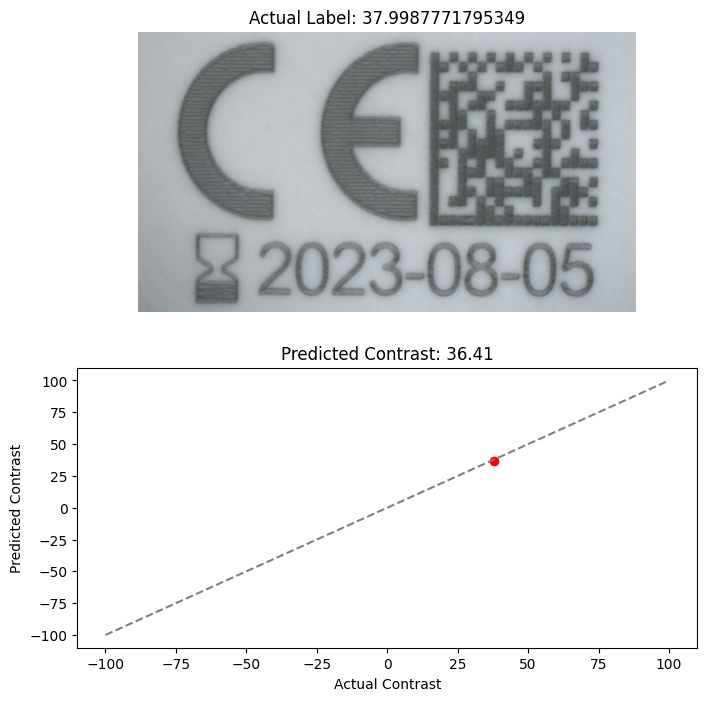

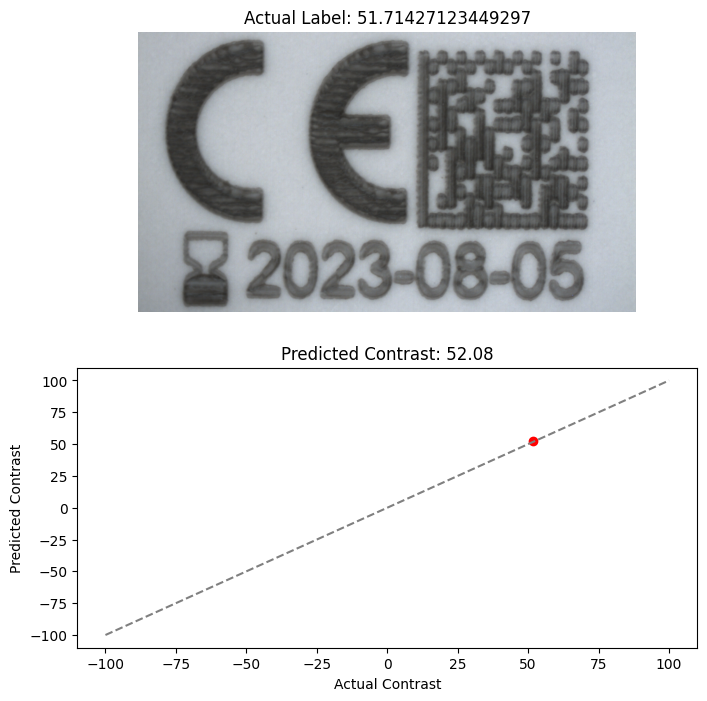

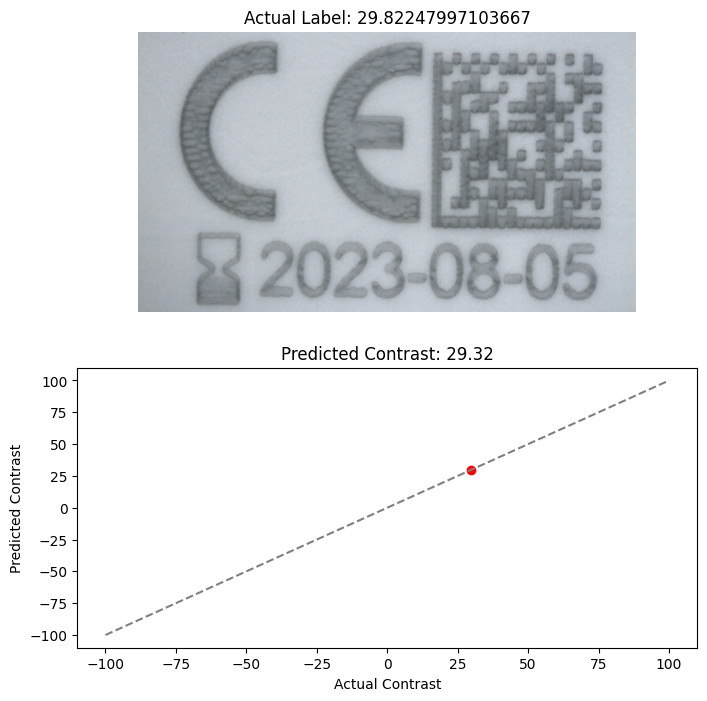

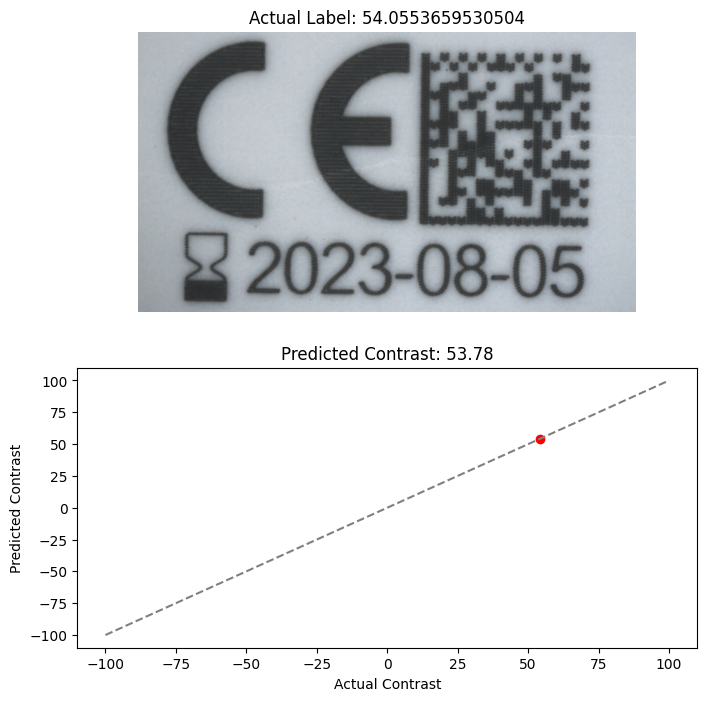

In [2]:
from matplotlib import image as mpimg 

# Your data directory
data_dir = r"E:\Documentos\01_DTU\DTU-TFM\Fotos\DOE\2\2 cropped"
image_exts = ['.tif']

# Load the model
model = tf.keras.models.load_model('CNN.model')

# Assuming df is your DataFrame containing 'Image' and 'Contrast' columns
# (Replace this with your actual DataFrame)
df = pd.read_csv(r"E:\Documentos\02_Programming\A-data-driven-approach-to-marking-of-plastic-materials-by-laser-micro-machining-2\Image processing\Contrast and Histograms\Contrast_results_DOE 2-2.csv")
label_dict = pd.Series(df['Contrast'].values, index=df['Image']).to_dict()

# Get a list of all .tif files in the directory
image_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if any(f.endswith(ext) for ext in image_exts)]

# Choose only the first 15 images for testing
image_files_subset = image_files[:15]

# Load Images and Labels
images = []
labels = []

# New size for the resized images
new_size = (512, 512)

for image_file in tqdm(image_files_subset, desc="Loading Images"):

    # Load image
    img = Image.open(image_file)
    img = img.resize(new_size)  # Resize the image
    img = np.array(img) / 255.0  # Convert to numpy array and normalize pixel values
    img = tf.cast(img, tf.float32) / 255.0
    
    # Get the corresponding label from the dictionary
    label = label_dict.get(os.path.basename(image_file), 'unknown')  # Use 'unknown' if label is not in the dictionary
    
    # Append to lists
    images.append(img)
    labels.append(label)

# Convert lists to arrays
images = np.array(images)
labels = np.array(labels)

# Check the shape of the first resized image and label
print("Shape of the first resized image:", images[0].shape)
print("Label of the first image:", labels[0])

# Predict using the loaded model
predictions = model.predict(images)

# Visualize the images with actual labels and predicted contrasts
for i in range(len(images)):
    plt.figure(figsize=(8, 8))
    
    # Actual image with actual label
    plt.subplot(2, 1, 1)
    img_actual = mpimg.imread(image_files_subset[i])
    plt.imshow(img_actual)
    plt.title(f"Actual Label: {labels[i]}")
    plt.axis('off')
    
    # Predicted contrast below the actual image
    plt.subplot(2, 1, 2)
    plt.plot([-100, 100], [-100, 100], '--', color='gray')  # Diagonal line
    plt.scatter(labels[i], predictions[i], color='red')
    plt.title(f"Predicted Contrast: {predictions[i][0]:.2f}")
    plt.xlabel('Actual Contrast')
    plt.ylabel('Predicted Contrast')
    
    plt.show()


In [3]:
# Evaluate the model on the test set
score = model.evaluate(images, labels, verbose=0)
print("Mean Squared Error (MSE):", score[1])

# Calculate additional metrics if needed
from sklearn.metrics import mean_absolute_error, r2_score

# Mean Absolute Error (MAE)
mae = mean_absolute_error(labels, predictions)
print("Mean Absolute Error (MAE):", mae)

# R-squared (R2) Score
r2 = r2_score(labels, predictions)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 1.0918558835983276
Mean Absolute Error (MAE): 0.875800276822991
R-squared (R2) Score: 0.9938533378609505
